In [1]:
import numpy as np      
import matplotlib.pyplot as plt 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import pandas as pd
from pathlib import Path, PurePath   
from tqdm.notebook import tqdm
import random
import os
import pickle
from sklearn.metrics import jaccard_score
import pandas as pd

In [2]:
pd.options.mode.chained_assignment = None

# 1. Implementing your own Shazam

## 1.1 Getting your data 

### Some utility function:

In [13]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure()
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    

In [16]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30
THRESHOLD = 0 
N_PERMUTATION=10
N_PERMUTATION_LSH=128

### Convert tracks in the dataset from mp3 format to wav format.

In [14]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

In [17]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

[  23   46   64   74  102  112  122  150  178  188  226  244  262  281
  299  317  327  346  374  393  403  422  450  479  526  544  563  577
  595  618  637  647  675  694  704  723  751  769  779  789  817  827
  845  859  882  901  915  938  949  978  996 1015 1034 1044 1072 1091
 1110 1129 1148 1167 1185 1195 1233 1252 1271 1281]


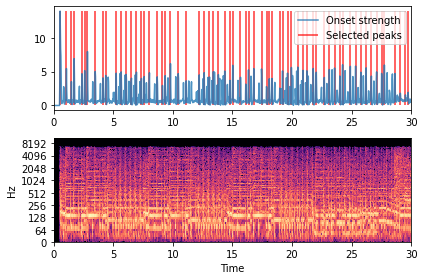

[  17   37   53   89  117  143  160  179  196  233  261  288  305  323
  339  385  402  430  448  467  484  519  547  574  592  612  629  655
  683  709  726  754  770  796  823  842  860  877  895  913  931  949
  966  984 1002 1018 1037 1054 1072 1089 1108 1125 1142 1178 1212 1240
 1266]


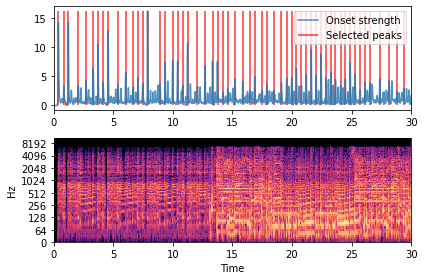

In [18]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    print(peaks)
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)

## 1.2 Fingerprint hashing

In [19]:
def track_vocabulary(tracks):
    voc={}
    i=1
    for track in tracks:
        name = os.path.basename(track)
        name=name[3:-4]

        path = os.path.normpath(track)
        final=path[14:]
        lst=final.partition('\\')
        author=lst[0]
        voc[i]=(name, author)
        i=i+1      
    return voc

In [ ]:
tracks = data_folder.glob("*/*/*.wav")
songs_vocabulary=track_vocabulary(tracks)
print(songs_vocabulary)

In [21]:
def random_number(n_permutation):
    random.seed(10010000)
    #our module is one of the Mersenne prime number, in particular the 8th 
    c=2147483647
    #as the ceil of the random number generator we had choosen the dimension of the unsigned long
    long=4294967295 
    a=random.sample(range(0, long), n_permutation)
    b=random.sample(range(0, long), n_permutation)
    return a, b, c

The logic behind the implementation of our LSH algorithm was the following: <br>
We considered each unique peak found in the songs' dataset as a shingle. After doing so, we created a matrix having n_shingles rows and n_tracks columns. Each column contains a specific track's signature, where the n-th cell of a column contains a 0 if the n-th shingle isn't found inside the track's list of peaks, and 1 if it does. <br>
Once we managed to create such matrix, it was time to compute a number of permutations to properly hash the signatures. To do so we shuffled the matrix for an arbitrary number of times (128), collecting for each permutation and for each track the first index at which a "1" appears: by combining these indexes, we get as a result our hashed signature.

### Peaks set

The first thing we needed to work on our own Shazam was to find every unique peak in our dataset. Since this proved to be quite a lenghty process, we decided to store them in a pickle file to access them immediately when needed.

In [22]:
def create_peaks_set(tracks):
    all_peaks=[]
    for track in tracks:
        _, _, _, peaks = load_audio_picks(track, DURATION, HOP_SIZE)
        for p in peaks:
            if p not in all_peaks:
                all_peaks.append(p)
                #print(p)
    all_peaks=sorted(all_peaks)
    return all_peaks



In [101]:
tracks = data_folder.glob("*/*/*.wav")
peaks=create_peaks_set(tracks)

In [59]:
open_file = open('./data/all_peaks.txt', "wb")

pickle.dump(peaks, open_file)

open_file.close()

In [23]:
open_file = open('./data/peaks.pkl', "rb")

all_peaks = pickle.load(open_file)

open_file.close()


### Shingles table and signature

The next step was to create our "shingles matrix". We create an empty matrix with shape " #of unique peaks X  #of tracks", and for each track (represented by a single column) change the value of each cell to 1 if the corresponding shingle is contained in said track's peaks' list.

As before, we save the final result in a pickle file to retrieve it easily.

In [24]:
def shingles_table(all_peaks, tracks, lens):

    matrix=np.zeros((len(all_peaks), lens), dtype=int)
    
    for i, track in enumerate(tracks):
        _, _, _, peaks = load_audio_picks(track, DURATION, HOP_SIZE)

        for j, p in enumerate(all_peaks):
            if p in peaks:
                matrix[j][i]=1
    
    return matrix
    

In [121]:
tracks = data_folder.glob("*/*/*.wav")
shingles_matrix=shingles_table(all_peaks, tracks, N_TRACKS)

In [ ]:
open_file = open('./data/matrix.pkl', "wb")

pickle.dump(shingles_matrix, open_file)

open_file.close()

In [25]:
open_file = open('./data/matrix.pkl', "rb")

shingles_matrix_2 = pickle.load(open_file)

open_file.close()


The next step was hashing the signatures. We did so by shuffling the matrix 128 times, and retrieving for each permutation the index of the first non-zero element of each column. What we end up with is a collection of hashed signatures that we will later use to implement our LSH algorithm. 

In [26]:
def signature_min_hash(matrix, n_permutation):

    signat=[]
    
    for _ in range(n_permutation):
        np.random.seed(10010000)
        np.random.shuffle(matrix)
        #calcolare la signature
        row=[]
        #extract the first element of the audio
        for i in range(0, len(matrix[0])):
            #print(i)
            element=0
            element=np.where(matrix[:, i]==1)[0][0]
            row.append(element)
        signat.append(row)

    return signat


In [117]:
signature_lsh=signature_min_hash(shingles_matrix_2, N_PERMUTATION_LSH)


In [14]:
open_file = open('./data/signature.pkl', "wb")

pickle.dump(signature_lsh, open_file)

open_file.close()

In [27]:
open_file = open('./data/signature.pkl', "rb")

signature = pickle.load(open_file)

open_file.close()

### Creating buckets

In [28]:
def custom_hash(A, n_band):
    a, b, c=random_number(n_band)
    a=np.asarray(a)
    a=np.asarray(b)
    A=np.asarray(A)

    return (np.sum(a*A+b))%c

In [30]:
def creating_bucket(matrix):

    bucket={} #dict with [ keys = song_index] : [values = list of bucket]
    inverted_bucket={}  #dict with [keys = list of bucket] : [ values = song_index] 
    n_band=8

    for i in range(len(matrix[0])):
        for j in range(0, N_PERMUTATION_LSH, n_band):
            key=[]
            for k in range(j, j+8):
                key.append(matrix[k][i])
            
            hash=custom_hash(key, n_band)


            if i not in bucket:
                bucket[i]=[]

            bucket[i].append(hash)

            #-----------------#

            if hash not in inverted_bucket:
                inverted_bucket[hash]=[]

            inverted_bucket[hash].append(i)


    return  bucket, inverted_bucket

In [31]:
song_buckets, bucket=creating_bucket(signature)


### Query preprocessing

In [37]:
data_folder = Path("data/query/")
query = data_folder.glob("*")
N_QUERY=10

#shingle
shingles=shingles_table(all_peaks, query, N_QUERY)

#signature
sig=signature_min_hash(shingles, N_PERMUTATION_LSH)

#bucket
song_buckets_query, bucket_query=creating_bucket(sig)

In [33]:
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(set(list1)) + len(set(list2))) - intersection
    return float(intersection) / union

In [34]:
def similarity(song_buckets_query, song_buckets, bucket, threshold):
    jaccard=[]
    for i in song_buckets_query:
        list_index_matched=[]
        values=song_buckets_query[i]
        for v in values:
            try:
                song_index=bucket[v]
                if song_index  not in list_index_matched:

                    list_index_matched.append(song_index)
                    set_buckets=song_buckets[song_index[0]]
                    j=jaccard_similarity(set_buckets, values)

                    if j > threshold:
                        jaccard.append((i, j, song_index))
            except:
                pass
            

    return jaccard

In [38]:
results=similarity(song_buckets_query, song_buckets, bucket, THRESHOLD)
for r in results:
    title=songs_vocabulary[int(r[2][0])+1]
    print('for query ', int(r[0])+1, " found song: ", title, " with similarity ", r[1])
    

for query  1  found song:  ('Dream_On', 'aerosmith')  with similarity  1.0
for query  2  found song:  ('I_Want_To_Break_Free', 'queen')  with similarity  1.0
for query  3  found song:  ('October', 'u2')  with similarity  1.0
for query  4  found song:  ('Ob-La-Di_Ob-La-Da', 'beatles')  with similarity  1.0
for query  5  found song:  ('Karma_Police', 'radiohead')  with similarity  1.0
for query  6  found song:  ('Heartbreaker', 'led_zeppelin')  with similarity  1.0
for query  7  found song:  ('Go_Your_Own_Way', 'fleetwood_mac')  with similarity  1.0
for query  8  found song:  ('American_Idiot', 'green_day')  with similarity  1.0
for query  9  found song:  ('Somebody', 'depeche_mode')  with similarity  1.0
for query  10  found song:  ('Black_Friday', 'steely_dan')  with similarity  1.0


### Different thresholds:

We tried experimenting with different values for our threshold, but the results were always the same since the queries are perfectly matched with one of the tracks in our dataset. We thought about the possibility of returning a set of matches above a certain threshold for each query, but our program is basically designed to either find a perfect match or avoid returning anything. We felt that this was actually a sensible implementation of such task, since we got inspired by real services (like Shazam) which either return an exact result or avoid returning anything altogether. 

# 2. Grouping songs together!

We play with a dataset gathering songs from the International Society for Music Information Retrieval Conference. The tracks (songs) include much information. We focus on the track information, features (extracted with librosa library from Python) and audio variables provided by Echonest (now Spotify).

The final goal is to group songs into similar genres, therefore DO NOT use the feature genre in your k-means anaylsis

To solve this task, you must accomplish the next stages:

## 2.1 Getting your data!

Access to the data can be found here:
echonest.csv
features.csv
tracks.csv
Data Scientists are often challenged to do Data Wrangling. The latter is a process of cleaning and unifying messy and complex data sets for easy access and analysis (see more info here). You are supposed to create one single data set by merging tracks.csv, features.csv and echonest.csv. It's your job to find the correct key to join your data sets together. You should end up with a data set of ~13K rows.

## 2.2 Choose your features (variables)!

As you may notice, you have plenty of features to work with. So, you need to find a way to reduce the dimensionality (reduce the number of variables to work with). You can follow the next directions to achieve it:

Select one method for dimensionality reduction and apply it to your data. Some suggestions are Principal Component Analysis, Multiple Correspondence Analysis, Singular Value Decomposition, Factor Analysis for Mixed Data, Two-Steps clustering. Make sure that the method you choose is applicable for the features you have or modify your data to be able to use it. Explain why you chose that method and the limitations it may have.
HINT: We don't want to miss relevant variables like song's duration, language, etc., after the dimensionality reduction. To keep those variables, you can apply the dimensionality reduction method(s) on features coming from the same file. Later you can stack them with the variables selected from another file.

Apply the selected method(s) to your data. Make sure that the chosen method retains > 70% of the total variance.

In [ ]:
dataset1 = pd.read_csv("/content/drive/MyDrive/ADM-HW4/CSVs/echonest.csv")

In [ ]:
dataset1.shape()

(13129, 250)

In [ ]:
dataset2 = pd.read_csv("/content/drive/MyDrive/ADM-HW4/CSVs/features.csv")

In [ ]:
dataset2.shape()

(106574, 519)

In [ ]:
dataset3 = pd.read_csv("/content/drive/MyDrive/ADM-HW4/CSVs/tracks.csv")

In [ ]:
dataset3.shape

(106574, 53)

We merge all 3 dataset togheter and we save the new dataset in a csv file:

In [ ]:
merge1 = pd.merge(dataset2, dataset3)

In [ ]:
merged_final = (dataset1.merge(merge1, on='track_id', how='left'))

In [ ]:
merged_final.shape

(13129, 820)

In [ ]:
merged_final.to_csv(r'/content/drive/MyDrive/ADM-HW4/CSVs/merged_final.csv', index = False, header=True)

In [ ]:
dataset=pd.read_csv("/content/drive/MyDrive/ADM-HW4/CSVs/merged_final.csv")

From the newdataset we split the numerical variables from the categorical variables.
newdataset is the new dataset with just numerical variables.

In [ ]:
newdataset=dataset.select_dtypes(exclude=['object'])
newdataset

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,metadata_artist_latitude,metadata_artist_longitude,ranks_artist_discovery_rank,ranks_artist_familiarity_rank,ranks_artist_hotttnesss_rank,ranks_song_currency_rank,ranks_song_hotttnesss_rank,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,...,tonnetz_min_03,tonnetz_min_04,tonnetz_min_05,tonnetz_min_06,tonnetz_skew_01,tonnetz_skew_02,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,album_comments,album_favorites,album_id,album_listens,album_tracks,artist_comments,artist_favorites,artist_id,artist_latitude,artist_longitude,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,32.6783,-83.22300,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,0.318376,0.371974,1.0000,0.5710,0.278,0.2100,0.2150,0.2285,0.2375,...,-0.185687,-0.140306,-0.048525,-0.089286,0.752462,0.262607,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,0,4,1,6073,7,0,9,1,40.058324,-74.405661,256000,0,168,2,4656,1293,3
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,32.6783,-83.22300,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,0.474559,0.406729,0.5060,0.5145,0.387,0.3235,0.2805,0.3135,0.3455,...,-0.164613,-0.304375,-0.024958,-0.055667,0.265541,-0.131471,0.171930,-0.990710,0.574556,0.556494,0.026316,0.018708,0.051151,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,0,4,1,6073,7,0,9,1,40.058324,-74.405661,256000,0,237,1,1470,514,4
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,32.6783,-83.22300,NaN,NaN,NaN,NaN,NaN,0.388990,0.386740,0.406370,0.000000,0.000000,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,0.425371,0.446896,0.5110,0.7720,0.361,0.2880,0.3310,0.3720,0.3590,...,-0.359463,-0.166667,-0.038546,-0.146136,1.212025,0.218381,-0.419971,-0.014541,-0.199314,-0.925733,0.025550,0.021106,0.084997,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,0,4,1,6073,7,0,9,1,40.058324,-74.405661,256000,0,206,6,1933,1151,6
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,39.9523,-75.16240,2635.0,2544.0,397.0,115691.0,67609.0,0.557339,0.614272,0.798387,0.005158,0.354516,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,0.368756,0.440775,0.2630,0.7360,0.273,0.4260,0.2140,0.2880,0.8100,...,-0.273549,-0.343055,-0.052284,-0.029836,-0.135219,-0.275780,0.015767,-1.094873,1.164041,0.246746,0.021413,0.031989,0.088197,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,0,4,6,47632,2,3,74,6,NaN,NaN,192000,0,161,178,54881,50135,1
4,134,0.452217,0.513238,

In [ ]:
newdataset.isnull().sum()

track_id                           0
audio_features_acousticness        0
audio_features_danceability        0
audio_features_energy              0
audio_features_instrumentalness    0
                                  ..
track_duration                     0
track_favorites                    0
track_interest                     0
track_listens                      0
track_number                       0
Length: 780, dtype: int64

In [ ]:
newdataset.isnull().any().sum()

9

In [ ]:
newdataset.isnull().sum().sort_values(ascending = False)

ranks_song_currency_rank         11096
ranks_song_hotttnesss_rank       10923
ranks_artist_hotttnesss_rank     10305
ranks_artist_familiarity_rank    10304
ranks_artist_discovery_rank      10304
                                 ...  
mfcc_kurtosis_19                     0
mfcc_kurtosis_18                     0
mfcc_kurtosis_17                     0
mfcc_kurtosis_16                     0
track_id                             0
Length: 780, dtype: int64

In [ ]:
newdataset.dropna(axis='columns', inplace=True)

In [ ]:
newdataset.shape

(13129, 771)

newdataset has just 9 columns with some NA values, so we drop this 9 columns and we will work with the 771 remaining.

Now we work with the qualitative variables:
we choose 6 variables that looks like important, and we recode it as numerical.

In [ ]:
newdataset2=dataset.select_dtypes(include=['object'])
newdataset2.shape

(13129, 40)

In [ ]:
newdataset2.groupby('album_type').count()

,metadata_album_date,metadata_album_name,metadata_artist_location,metadata_artist_name,metadata_release,album_date_created,album_date_released,album_engineer,album_information,album_producer,album_tags,album_title,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_date_created,artist_location,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_composer,track_date_created,track_date_recorded,track_genre_top,track_genres,track_genres_all,track_information,track_language_code,track_license,track_lyricist,track_publisher,track_tags,track_title
album_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Album,2515,2668,6595,9549,9549,9549,6404,736,7492,1067,9549,9549,1973,365,1208,6528,9498,6247,4337,9549,1013,9549,7331,485,9549,9549,351,9549,1113,6565,9549,9549,310,3789,9521,40,110,9549,9548
Contest,0,0,7,14,14,14,0,0,14,0,14,14,5,1,3,6,14,8,4,14,0,14,8,0,14,14,0,14,2,0,14,14,3,1,14,0,0,14,14
Live Performance,37,37,1006,1178,1178,1178,925,599,1060,489,1178,1178,389,56,340,1020,1178,932,840,1178,222,1178,1063,199,1178,1178,83,1178,460,881,1178,1178,164,657,1162,13,12,1178,1178
Radio Program,88,88,1802,1943,1943,1943,1857,1547,1852,1368,1943,1943,576,36,622,1762,1943,1606,1376,1943,420,1943,1765,457,1943,1943,36,1943,724,1602,1943,1943,312,1173,1923,11,17,1943,1943
Single Tracks,20,22,118,142,142,142,106,7,98,10,142,142,42,16,55,125,142,112,94,142,57,142,116,20,142,142,33,142,69,111,142,142,24,123,142,1,2,142,142


In [ ]:
newdataset2.head(1000)

,metadata_album_date,metadata_album_name,metadata_artist_location,metadata_artist_name,metadata_release,album_date_created,album_date_released,album_engineer,album_information,album_producer,album_tags,album_title,album_type,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_date_created,artist_location,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_composer,track_date_created,track_date_recorded,track_genre_top,track_genres,track_genres_all,track_information,track_language_code,track_license,track_lyricist,track_publisher,track_tags,track_title
0,NaN,NaN,"Georgia, US",AWOL,AWOL - A Way Of Life,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,<p></p>,NaN,[],AWOL - A Way Of Life,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,Hip-Hop,[21],[21],NaN,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,NaN,NaN,[],Food
1,NaN,NaN,"Georgia, US",AWOL,AWOL - A Way Of Life,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,<p></p>,NaN,[],AWOL - A Way Of Life,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,Hip-Hop,[21],[21],NaN,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,NaN,NaN,[],Electric Ave
2,NaN,NaN,"Georgia, US",AWOL,AWOL - A Way Of Life,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,<p></p>,NaN,[],AWOL - A Way Of Life,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,Hip-Hop,[21],[21],NaN,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,NaN,NaN,[],This World
3,2008-03-11,Constant Hitmaker,"Philadelphia, PA, US",Kurt Vile,Constant Hitmaker,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,NaN,NaN,[],Constant Hitmaker,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",2008-11-26 01:42:55,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,Pop,[10],[10],NaN,en,Attribution-NonCommercial-NoDerivatives (aka M...,NaN,NaN,[],Freeway
4,NaN,NaN,"Georgia, US",AWOL,AWOL - A Way Of Life,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,<p></p>,NaN,[],AWOL - A Way Of Life,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",2008-11-26 01:42:32,New Jersey,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,NaN,2008-11-26 01:43:19,2008-11-26 00:00:00,Hip-Hop,[21],[21],NaN,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,NaN,NaN,[],Street Music
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,"Austin, TX, US",Chandeliers,Live at WFMU on Talk's Cheap 10/14/2008,2008-12-04 09:27:17,2008-10-14 00:00:00,Jason Sigal with Adrian Caballero,"<p>Image: Chris Kalis (yellow), Dan Jugle (bot...",Jason Sigal,[],Live at WFMU on Talk's Cheap 10/14/2008,Live Performance,2004-01-01 00:00:00,NaN,"Captcha Records (HBSP-2X), Pickled Egg (Europe)","<p><span style

In [ ]:
newdataset2.isnull().sum().sort_values(ascending = False)

track_lyricist              13055
track_publisher             12977
artist_active_year_end      12635
track_composer              12605
track_information           12310
artist_wikipedia_page       11898
artist_related_projects     11385
artist_associated_labels    10872
track_date_recorded         10714
metadata_album_date         10412
metadata_album_name         10257
album_engineer              10226
album_producer              10184
artist_active_year_begin    10081
track_language_code          7306
artist_members               6369
artist_location              4046
album_date_released          3817
track_genre_top              3774
artist_bio                   3490
metadata_artist_location     3359
artist_website               2658
album_information            2548
album_type                    303
album_date_created            191
track_license                  64
artist_date_created            52
track_title                     1
artist_tags                     0
album_tags    

In [ ]:
newdataset2["album_year"]=newdataset2["album_date_created"].str[:4]

In [ ]:
newdataset2['album_title']=pd.factorize(newdataset2.album_title)[0]

In [ ]:
newdataset2["artist_name"]=pd.factorize(newdataset2.artist_name)[0]

In [ ]:
newdataset2["track_language_code"]=pd.factorize(newdataset2.track_language_code)[0]  #rende i NA -1

In [ ]:
newdataset2["album_type"]=pd.factorize(newdataset2.album_type)[0] #tutti zero

In [ ]:
newdataset2["metadata_artist_location"]=pd.factorize(newdataset2.metadata_artist_location)[0]

In [ ]:
datasetridotto=newdataset2[["album_year","album_title","artist_name","track_language_code","album_type","metadata_artist_location"]]
datasetridotto

,album_year,album_title,artist_name,track_language_code,album_type,metadata_artist_location
0,2008,0,0,0,0,0
1,2008,0,0,0,0,0
2,2008,0,0,0,0,0
3,2008,1,1,0,0,1
4,2008,0,0,0,0,0
...,...,...,...,...,...,...
13124,2015,2439,2872,-1,0,832
13125,2015,2439,2872,-1,0,832
13126,2015,2439,2872,-1,0,832
13127,2015,2439,2872,-1,0,832


In [ ]:
newdataset2.groupby('album_type').count()

,metadata_album_date,metadata_album_name,metadata_artist_location,metadata_artist_name,metadata_release,album_date_created,album_date_released,album_engineer,album_information,album_producer,album_tags,album_title,artist_active_year_begin,artist_active_year_end,artist_associated_labels,artist_bio,artist_date_created,artist_location,artist_members,artist_name,artist_related_projects,artist_tags,artist_website,artist_wikipedia_page,set_split,set_subset,track_composer,track_date_created,track_date_recorded,track_genre_top,track_genres,track_genres_all,track_information,track_language_code,track_license,track_lyricist,track_publisher,track_tags,track_title,album_year
album_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-1,57,57,303,303,303,112,20,14,65,11,303,303,63,20,29,198,302,178,109,303,32,303,188,70,303,303,21,303,47,196,303,303,6,303,303,9,11,303,303,112
0,2515,2668,9549,9549,9549,9549,6404,736,7492,1067,9549,9549,1973,365,1208,6528,9498,6247,4337,9549,1013,9549,7331,485,9549,9549,351,9549,1113,6565,9549,9549,310,9549,9521,40,110,9549,9548,9549
1,20,22,142,142,142,142,106,7,98,10,142,142,42,16,55,125,142,112,94,142,57,142,116,20,142,142,33,142,69,111,142,142,24,142,142,1,2,142,142,142
2,37,37,1178,1178,1178,1178,925,599,1060,489,1178,1178,389,56,340,1020,1178,932,840,1178,222,1178,1063,199,1178,1178,83,1178,460,881,1178,1178,164,1178,1162,13,12,1178,1178,1178
3,88,88,1943,1943,1943,1943,1857,1547,1852,1368,1943,1943,576,36,622,1762,1943,1606,1376,1943,420,1943,1765,457,1943,1943,36,1943,724,1602,1943,1943,312,1943,1923,11,17,1943,1943,1943
4,0,0,14,14,14,14,0,0,14,0,14,14,5,1,3,6,14,8,4,14,0,14,8,0,14,14,0,14,2,0,14,14,3,14,14,0,0,14,14,14


As we can see from the cells above, now we have a dataset with 6 numerical variables.

We combine the 2 different datasets, so we obtain a dataset with all numerical variables.
we notice that 'album_year' has 191 NA values, so we drop that rows, and we will calculate the pca in the remaining.

In [ ]:
tot=pd.concat((newdataset, datasetridotto), axis=1)
tot

,track_id,audio_features_acousticness,audio_features_danceability,audio_features_energy,audio_features_instrumentalness,audio_features_liveness,audio_features_speechiness,audio_features_tempo,audio_features_valence,social_features_artist_discovery,social_features_artist_familiarity,social_features_artist_hotttnesss,social_features_song_currency,social_features_song_hotttnesss,temporal_features_000,temporal_features_001,temporal_features_002,temporal_features_003,temporal_features_004,temporal_features_005,temporal_features_006,temporal_features_007,temporal_features_008,temporal_features_009,temporal_features_010,temporal_features_011,temporal_features_012,temporal_features_013,temporal_features_014,temporal_features_015,temporal_features_016,temporal_features_017,temporal_features_018,temporal_features_019,temporal_features_020,temporal_features_021,temporal_features_022,temporal_features_023,temporal_features_024,temporal_features_025,...,tonnetz_skew_01,tonnetz_skew_02,tonnetz_skew_03,tonnetz_skew_04,tonnetz_skew_05,tonnetz_skew_06,tonnetz_std_01,tonnetz_std_02,tonnetz_std_03,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,album_comments,album_favorites,album_id,album_listens,album_tracks,artist_comments,artist_favorites,artist_id,track_bit_rate,track_comments,track_duration,track_favorites,track_interest,track_listens,track_number,album_year,album_title,artist_name,track_language_code,album_type,metadata_artist_location
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,0.388990,0.386740,0.406370,0.000000,0.000000,0.877233,0.588911,0.354243,0.295090,0.298413,0.309430,0.304496,0.334579,0.249495,0.259656,0.318376,0.371974,1.0000,0.5710,0.278,0.2100,0.2150,0.2285,0.2375,0.2790,0.1685,0.1685,0.279,0.3325,0.049848,0.104212,...,0.752462,0.262607,0.200944,0.593595,-0.177665,-1.424201,0.019809,0.029569,0.038974,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,0,4,1,6073,7,0,9,1,256000,0,168,2,4656,1293,3,2008,0,0,0,0,0
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,0.388990,0.386740,0.406370,0.000000,0.000000,0.534429,0.537414,0.443299,0.390879,0.344573,0.366448,0.419455,0.747766,0.460901,0.392379,0.474559,0.406729,0.5060,0.5145,0.387,0.3235,0.2805,0.3135,0.3455,0.8980,0.4365,0.3385,0.398,0.3480,0.079207,0.083319,...,0.265541,-0.131471,0.171930,-0.990710,0.574556,0.556494,0.026316,0.018708,0.051151,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330,0,4,1,6073,7,0,9,1,256000,0,237,1,1470,514,4,2008,0,0,0,0,0
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,0.388990,0.386740,0.406370,0.000000,0.000000,0.548093,0.720192,0.389257,0.344934,0.361300,0.402543,0.434044,0.388137,0.512487,0.525755,0.425371,0.446896,0.5110,0.7720,0.361,0.2880,0.3310,0.3720,0.3590,0.2790,0.4430,0.4840,0.368,0.3970,0.081051,0.078300,...,1.212025,0.218381,-0.419971,-0.014541,-0.199314,-0.925733,0.025550,0.021106,0.084997,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,0,4,1,6073,7,0,9,1,256000,0,206,6,1933,1151,6,2008,0,0,0,0,0
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,0.557339,0.614272,0.798387,0.005158,0.354516,0.311404,0.711402,0.321914,0.500601,0.250963,0.321316,0.734250,0.325188,0.373012,0.235840,0.368756,0.440775,0.2630,0.7360,0.273,0.4260,0.2140,0.2880,0.8100,0.2460,0.2950,0.1640,0.311,0.3860,0.033969,0.070692,...,-0.135219,-0.275780,0.015767,-1.094873,1.164041,0.246746,0.021413,0.031989,0.088197,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,0,4,6,47632,2,3,74,6,192000,0,161,178,54881,50135,1,2008,1,1,0,0,1
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,0.388990,0.386740,0.406370,0.000000,0.000000,0.610849,0.569169,0.428494,0.345796,0.376920,0.460590,0.401371,0.449900,

In [ ]:
tot.isnull().sum().sort_values(ascending = False)

album_year                  191
metadata_artist_location      0
chroma_cens_max_05            0
chroma_cens_mean_03           0
chroma_cens_mean_02           0
                           ... 
mfcc_max_05                   0
mfcc_max_04                   0
mfcc_max_03                   0
mfcc_max_02                   0
track_id                      0
Length: 777, dtype: int64

In [ ]:
tot.dropna(axis='rows', inplace=True)

In [ ]:
tot.shape

(12938, 777)

In the cells below we standardize our dataset, and then we compute the pca.


We choose 67 number of components to explain 70% of the variance.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler 

In [ ]:
sc = StandardScaler()
totZ=sc.fit_transform(tot)
totZ

array([[-1.17485001, -0.28358435,  0.99332415, ...,  0.37454311,
        -0.55141766, -0.72055584],
       [-1.17481527, -0.3937955 ,  0.21901247, ...,  0.37454311,
        -0.55141766, -0.72055584],
       [-1.1747458 , -1.25645322,  1.3596903 , ...,  0.37454311,
        -0.55141766, -0.72055584],
       ...,
       [ 3.16248186, -1.36972836,  0.64517436, ..., -0.48617425,
        -0.55141766,  2.47228014],
       [ 3.1625166 , -0.51590711,  0.45976038, ..., -0.48617425,
        -0.55141766,  2.47228014],
       [ 3.16414925,  1.22074599,  0.06491886, ..., -0.48617425,
        -0.55141766,  2.59508152]])

In [ ]:
pca = PCA(n_components=67)
pca.fit(totZ)
sum(pca.explained_variance_ratio_)

0.7021000865597691

In [ ]:
pd.DataFrame(data = pca)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66
0,3.063444,-2.776914,-6.051120,4.077808,3.381050,2.004396,6.745467,-1.200744,-2.223432,3.883829,-5.134176,1.903384,-2.274726,6.024618,0.615915,2.333328,-1.503327,-0.077671,-3.370398,-0.637622,-2.384066,-0.138380,-0.673550,-0.975062,2.169045,-2.353450,-0.314237,-0.845599,-1.022021,3.555234,-1.193104,2.089705,0.010173,-0.889000,-1.193295,0.294284,1.879396,-1.559249,1.964519,-1.568205,1.422364,-3.299135,-0.798331,0.493497,-1.875524,1.529689,-0.781360,-1.050177,2.177662,-1.300286,-0.339727,0.276197,-0.753049,1.345074,-0.964781,-0.236656,-1.182398,-1.331722,0.102914,-1.463243,-0.566010,2.531509,-0.305359,1.013535,-0.411635,-0.600533,1.111129
1,5.760802,-5.380093,-5.586537,-1.323214,-3.510960,2.775620,-1.550137,5.793802,-0.032693,4.288859,-2.302970,2.381996,0.664237,3.859819,2.437512,-0.282549,-2.133979,-2.814444,-3.027503,-2.302427,-0.093410,-1.681422,0.571879,1.385973,3.414223,-0.739563,1.205972,-0.665621,-1.529400,0.729855,-0.709027,1.714388,0.076656,-0.623317,-0.633394,1.762597,-0.278076,-2.424804,1.761806,2.641107,-0.066840,-2.114350,1.759915,-0.977260,-2.480238,1.897409,-2.141141,-0.679668,-0.358235,-0.592056,0.149567,-1.461887,-1.650063,-1.176618,-1.178570,-0.367791,-1.760081,-0.718352,-0.250378,-0.776135,0.909689,1.056889,0.627820,-0.625659,-0.371184,-0.516862,-2.187021
2,2.634166,-4.122254,-4.874257,0.185239,-2.821966,2.165899,-1.367479,-0.376665,-0.065471,1.691731,-2.234451,3.424580,-1.439319,3.037465,0.699762,1.762335,-1.613896,-2.300768,-3.362104,1.528783,-3.552374,0.140213,1.576212,2.768173,2.101408,-1.840269,1.525060,-0.868745,-0.546142,0.096027,-1.001823,-0.067959,-2.043444,2.164531,-1.839581,-1.271131,0.555763,-1.129423,0.268028,1.626603,0.923135,-2.592816,1.055527,-0.157011,-1.960759,0.404655,1.400108,-3.206473,0.954100,0.583197,-1.171094,-0.062076,-2.328909,1.035427,-1.920285,0.677606,-2.440301,-1.225314,-0.632991,-0.075071,-1.199949,0.308637,0.501644,-1.832479,-2.082602,-0.310304,0.524956
3,9.108417,3.801423,-5.778498,0.919814,-1.277886,0.636063,-1.675957,4.051569,-0.426298,4.743543,-2.519856,5.995988,3.184619,-0.587698,-1.727912,-3.344549,2.852993,-1.207559,-3.415535,2.031393,-2.579621,1.058341,-4.857669,-1.191417,0.849411,-0.267606,-0.187508,-3.094307,5.848678,2.593220,4.599854,3.552863,0.402048,1.115663,1.415066,-0.201860,-5.356338,-2.995787,-0.443071,0.334189,1.701706,-2.590388,1.129402,0.594803,-1.797212,0.624706,-0.693601,-1.217780,0.713816,2.101633,-2.288443,-0.825095,1.274493,1.268940,0.800895,-0.917183,-0.527662,0.083781,0.000653,-0.783206,0.055462,2.919057,-0.085680,2.081114,-1.625198,0.129006,-5.309464
4,1.278666,-9.390796,-4.761812,1.221546,-4.187134,-1.184899,-2.874739,-2.221013,-0.457421,2.635844,-0.730096,1.379151,-0.206004,1.413827,-0.546734,3.310940,0.683315,-1.945103,-2.383061,-1.533671,0.287182,-0.592841,1.833323,-0.014066,0.124238,-2.970698,1.975702,-0.839224,-0.093018,1.919327,0.871588,-0.120542,-1.407027,-1.056772,-1.802780,-1.272395,0.845046,-0.806317,-1.207209,1.729190,1.351752,-1.134703,-0.966012,-0.221533,-0.361805,1.212352,-0.761752,0.209687,-0.204154,0.941916,-0.678507,-0.119533,0.368099,1.056348,0.729960,-0.219013,-1.367424,-1.523176,-1.222881,-1.348817,1.990805,2.048324,1.772790,-3.335850,-0.622067,-0.710724,-0.751979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12933,7.717199,-5.873585,-0.449591,-2.323565,-1.381646,0.904225,1.358760,-0.561394,-0.934421,0.445077,-0.405711,5.497151,-2.813398,2.681725,-0.168346,-2.444946,-0.201354,-4.377291,3.262755,3.207983,2.865202,1.834427,0.065147,-0.886421,1.539836,-1.378217,-0.677855,-1.027845,-2.364794,-0.135529,1.004974,-1.242423,1.58

## 2.3 Clustering!


1. *Implement the K-means clustering algorithm (not ++: random initialization). We ask you to write the algorithm from scratch following what you learned in class.*

In [ ]:
import pandas as pd
data=pd.read_csv("/content/drive/MyDrive/ADM-HW4/CSVs/pca.csv")
first_column = data.columns[0]
data.drop([first_column], axis=1)
X=data

In [ ]:
from scipy.spatial.distance import cdist
def update_assignments(X, centroids):
    d = cdist(X, centroids, 'euclidean')
    c = [np.argmin(x) for x in d]
    return np.array(c),d
def update_centroids(X, num_clusters, assignments):
    cen=[]
    for c in range(num_clusters):
        cen.append(X[assignments==c].mean(axis=0))
    return np.array(cen)
def kmeans_filo(X,K):
    n=X.shape[0]
    centroids = []
    for i in range(K):
        rand=rd.randint(0,n-1)
        centroids.append(X.iloc[rand, :])
    centroids = np.array(centroids)
    for j in range(100):
        assignments, distance=update_assignments(X, centroids)
        centroids_old=centroids
        centroids=update_centroids(X, K, assignments)
        dist=np.mean(distance)
        if np.array_equal(centroids,centroids_old):
            print(f'Converged at {j}')
            break
    distanza=0
    for i in range(len(distance)):
      j=assignments[i]
      distanza=distanza+distance[i][j]
    return distanza,assignments,centroids

2. *Find an optimal number of clusters. Use at least two different methods. In case that your algorithms provide different optimal K's, select one of them and explain why you chose it.*

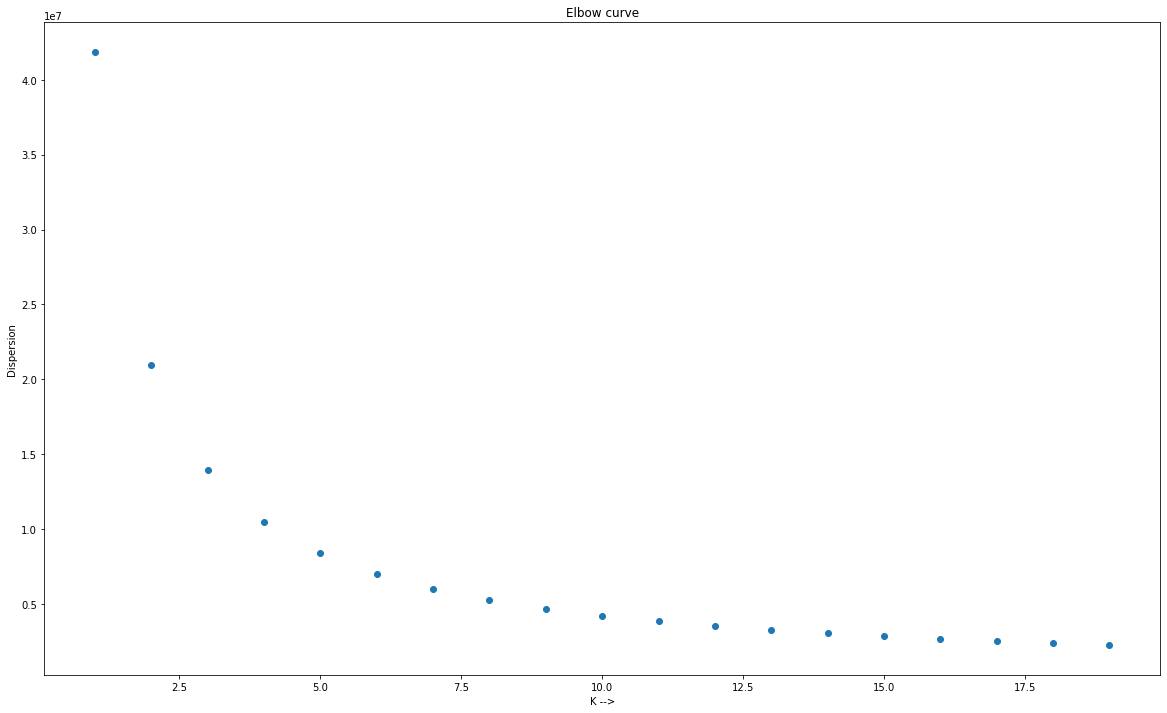

In [ ]:
ordinata=[]
for i in range(1,20):
  ordinata.append(kmeans_filo(X,i)[0])
ascissa=[]
[ascissa.append(i) for i in range(1,20)]
import matplotlib.pyplot as plt
plt.figure(figsize = (20,12))
plt.scatter(ascissa, ordinata)
plt.title("Elbow curve")
plt.xlabel("K -->")
plt.ylabel("Dispersion")
plt.show()

As we can see from the graph below, there is no real eblow so the best cluster cardinality to choose before getting a full flat function is 11, which is compatible with our purpose (grouping the songs in the data frame in cluster based on musical genre).

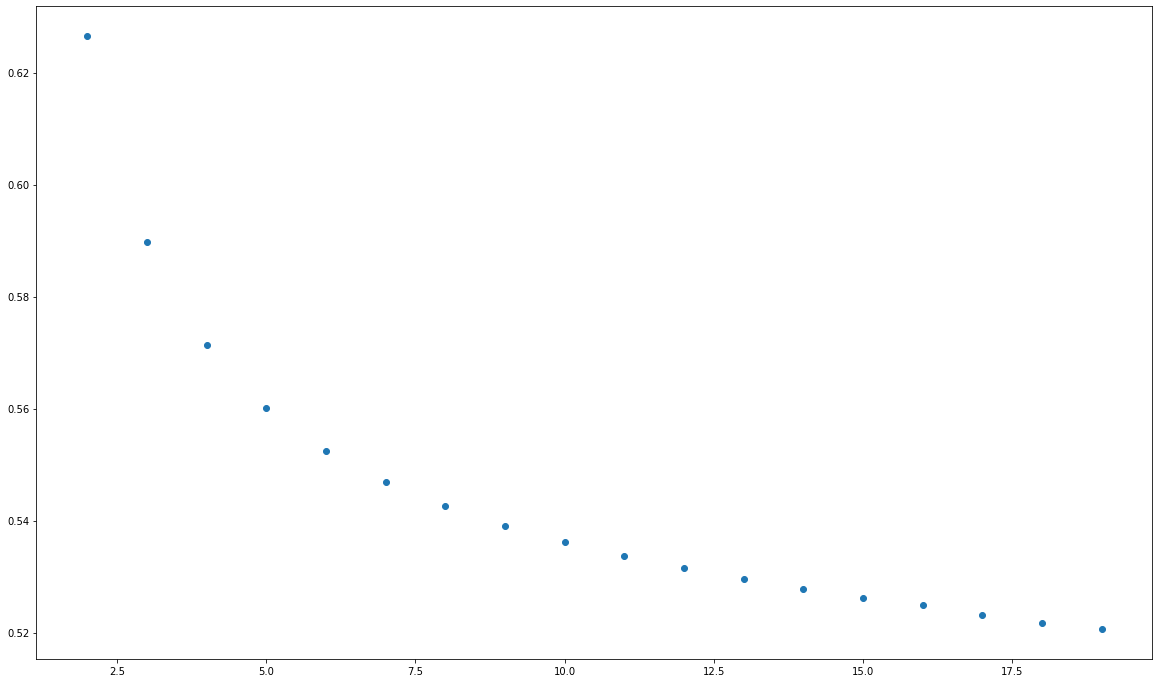

In [ ]:
from sklearn.metrics import silhouette_score
ordinata=[]
for i in range(2,20):
  laab=kmeans_filo(X,i)
  ordinata.append(silhouette_score(X,kmeans_filo(X,i)[1],metric='euclidean'))
ascissa=[]
[ascissa.append(i) for i in range(2,20)]
import matplotlib.pyplot as plt
plt.figure(figsize = (20,12))
plt.scatter(ascissa, ordinata)
plt.show()

The same append in the silhouette where there isn't a real pick, so essentialy we prefer to lower our goal and split in ~11 clusters of songs.

3. *Run the algorithm on the data that you got from the dimensionality reduction.*

In [ ]:
print(kmeans_filo(X,11))

(3854609.2008722927, array([8, 8, 8, ..., 4, 4, 4]), array([[ 4.85150000e+03, -1.99702695e+00,  1.89736685e+00,
        -2.09564090e+00,  6.83507691e-01, -7.66298401e-01,
        -6.31978754e-01, -9.77604112e-02, -1.69042634e-01,
        -6.76000176e-01,  1.43445930e-01,  1.07524138e+00,
         3.62706804e-02,  4.08909870e-01,  4.29255390e-02,
        -1.65114974e-01,  6.22400601e-01, -3.81942948e-02,
         1.85452898e-01,  3.29825748e-01, -4.41119701e-01,
        -5.50466237e-01, -4.90417273e-01, -2.87086160e-01,
        -2.18740020e-01, -1.07578346e-01,  5.99597646e-02,
        -1.16283392e-01,  1.84956750e-01, -7.61772827e-02,
         4.26392845e-02,  1.28213284e-01, -1.41369554e-01,
        -6.55400797e-02, -2.63832484e-01, -3.87678762e-02,
         2.48714650e-01,  9.68195296e-03, -7.02503574e-02,
        -3.74896796e-03, -5.47406870e-02,  1.31815143e-01,
        -7.89390629e-02,  1.25046816e-01, -5.84628933e-02,
        -3.17399877e-02,  2.30713832e-01,  1.19158500e-01,
   

4. *Then, use the already implemented version of k-means++ (from the scikit-learn library). Explain the differences (if there are any) in the results.*

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
data=pd.read_csv("/content/drive/MyDrive/ADM-HW4/CSVs/pca.csv")
data=data.to_numpy()
K=KMeans(n_clusters=11, init='k-means++').fit(data)
centers=K.cluster_centers_
dista=0
d=cdist(data, centers, 'euclidean')
for i in range(data.shape[0]):
  j=K.labels_[i]
  dista=dista+d[i][j]
mioK=kmeans_filo(X,11)
print(dista,mioK[0])
print(confusion_matrix(mioK[1], K.labels_))

3829736.7968423762 3829602.3461195384
[[   0    0    0    0 1140    0    0    0    0    0   23]
 [   0   15    0    0    0    0 1173    0    0    0    0]
 [   0    0    0   27    0    0    0    0 1149    0    0]
 [   8    0    0    0    0    0    0    0    0 1152    0]
 [   0    0    0    0    0 1192    0    0    0    0    0]
 [   0    0    0    0    0    0   21 1165    0    0    0]
 [   0    0   27    0    0    0    0    0    0    0 1140]
 [   0 1183    0    0    0    7    0    0    0    0    0]
 [   0    0 1143    0    0    0    0    0   29    0    0]
 [   0    0    0 1156    0    0    0   26    0    0    0]
 [1145    0    0    0   17    0    0    0    0    0    0]]


Comparing the results of our algorithm and the Kmeans++, as is showed by the confusion matrix and by the measures of distances obtained in the final step...the results are really close each other, but of course Kmeans++ works better in the initial step to assigning centroids in order to rappresent the entire distribution of points in the space.

## 2.4 Analysing your results!

*You are often encouraged to explain what are the main characteristics that your clusters have. This is called the Characterizing Clusters step. Thus, follow the next steps to do it:*

In [ ]:
tot=pd.concat((newdataset, datasetridotto), axis=1)#Condtinuos and descreate varaibles.
tot.dropna(axis='rows', inplace=True)

In [ ]:
assignments=kmeans_filo(X,11)[1]
tot["Kluster"]=assignments
TTT=tot.merge(dataset,left_on='track_id',right_on='track_id')

1. *Select 5-10 variables (from the ones that you had before doing the dimensionality reduction step) you think are relevant to identify the genre of a song. For example, Duration, Language, Country, etc.*

2. *If any of your selected variables are numerical (continuous or discrete), then categorize them into 4 categories.*

3. *With the selected variables, perform pivot tables. On the horizontal axis, you will have the clusters, and on the vertical axis, you will have the categories of each variable. Notice that you have to do one pivot table per variable.*

4. *Calculate the percentage by column for each pivot table. It means that the sum of each column (cluster) must be 1. See the next example for the variable "Song's Continent" with a hypothetical K = 4:*

In [ ]:
CT=pd.crosstab(index=TTT['album_type_y'], columns=TTT['Kluster'],normalize='columns').round(2)
CT.loc['Total'] = CT.sum()
CT

Kluster,0,1,2,3,4,5,6,7,8,9,10
album_type_y,,,,,,,,,,,
Album,0.64,0.63,0.29,0.89,0.84,0.84,0.75,0.90,0.87,0.79,0.76
Contest,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
Live Performance,0.08,0.09,0.29,0.06,0.03,0.06,0.12,0.07,0.05,0.05,0.10
Radio Program,0.21,0.27,0.42,0.04,0.13,0.09,0.13,0.03,0.07,0.16,0.12
Single Tracks,0.07,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.02
Total,1.00,1.00,1.00,0.99,1.00,0.99,1.00,1.00,1.01,1.00,1.00


Our clustering procedure produce groups that of course contain a lot of album tracks (because is the most frequent type of track), but meanwhile are able to divide "Radio Program" type of songs essentially in the first 3 clusters.

5. *Interpret the results for each pivot table.*

In [ ]:
CT=pd.crosstab(index=TTT['track_language_code_y'], columns=TTT['Kluster'],normalize='columns').round(2)
CT.loc['Total'] = CT.sum()
CT

Kluster,0,1,2,3,4,5,6,7,8,9,10
track_language_code_y,,,,,,,,,,,
ar,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
bm,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
cs,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.03,0.00,0.00,0.00
de,0.0,0.00,0.00,0.00,0.4,0.00,0.06,0.02,0.00,0.00,0.00
el,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00
en,1.0,0.67,0.97,0.37,0.6,0.97,0.00,0.36,0.00,0.97,0.98
es,0.0,0.33,0.01,0.12,0.0,0.01,0.59,0.57,0.68,0.00,0.02
fi,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.02,0.00,0.00,0.00
fr,0.0,0.00,0.00,0.00,0.0,0.01,0.00,0.00,0.32,0.00,0.00


As showed our cluster are good enought to divide songs following the language, in fact the 1st group is completly in english and the 3th one is, for the most part, in spanish or portuguese, following the latin pattern.

In [ ]:
CCCC=TTT["album_date_created"].str[:4]
CT=pd.crosstab(index=CCCC, columns=TTT['Kluster'],normalize='columns').round(2)
CT.loc['Total'] = CT.sum()
CT

Kluster,0,1,2,3,4,5,6,7,8,9,10
album_date_created,,,,,,,,,,,
2008,0.95,0.00,0.46,0.00,0.00,0.02,0.00,0.0,0.01,0.01,0.02
2009,0.05,0.00,0.54,0.03,0.02,0.98,0.01,0.0,0.00,0.61,0.98
2010,0.00,0.00,0.00,0.97,0.01,0.00,0.00,1.0,0.70,0.38,0.00
2011,0.00,0.31,0.00,0.00,0.00,0.00,0.99,0.0,0.30,0.00,0.00
2012,0.00,0.51,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00
2013,0.00,0.18,0.00,0.00,0.24,0.00,0.00,0.0,0.00,0.00,0.00
2014,0.00,0.00,0.00,0.00,0.40,0.00,0.00,0.0,0.00,0.00,0.00
2015,0.00,0.00,0.00,0.00,0.33,0.00,0.00,0.0,0.00,0.00,0.00
Total,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.01,1.00,1.00


In this table we can notice how the clusters are discriminant for the year of production of the observations (songs), in fact almost each cluster has a specific year. 
Look the 6th totally produced in 2011, the 10th in 2009...

In [ ]:
CT=pd.crosstab(index=TTT['album_title_y'], columns=TTT['Kluster'],normalize='columns').round(2)
CT.loc['Total'] = CT.sum()
CT

Kluster,0,1,2,3,4,5,6,7,8,9,10
album_title_y,,,,,,,,,,,
"""Fresh Born"" Covers",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"""I Stayed Home ..."" (single)",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"""Killer Workout Mix"" compilation",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"""Let me get that Digital.""",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
"""Sex Drive"" b/w ""Patio Set"" 7""",0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...
whatwhat?,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
zinzin cobra!,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
É Português Não Gosto!,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
TTT["dance"]=pd.cut(TTT["audio_features_danceability_x"],np.arange(0, 1.25, 0.25), labels=["zero","low","medium","high"])
CT=pd.crosstab(index=TTT["dance"], columns=TTT['Kluster'],normalize='columns').round(2)
CT

Kluster,0,1,2,3,4,5,6,7,8,9,10
dance,,,,,,,,,,,
zero,0.19,0.11,0.19,0.13,0.07,0.10,0.14,0.08,0.13,0.08,0.10
low,0.52,0.42,0.55,0.36,0.38,0.38,0.39,0.34,0.36,0.38,0.38
medium,0.25,0.41,0.24,0.38,0.44,0.42,0.40,0.44,0.38,0.42,0.39
high,0.04,0.07,0.02,0.13,0.10,0.11,0.08,0.14,0.13,0.12,0.13


In [ ]:
TTT["energy"]=pd.cut(TTT["audio_features_energy_x"],np.arange(0, 1.25, 0.25), labels=["zero","low","medium","high"])
CT=pd.crosstab(index=TTT["energy"], columns=TTT['Kluster'],normalize='columns').round(2)
CT

Kluster,0,1,2,3,4,5,6,7,8,9,10
energy,,,,,,,,,,,
zero,0.21,0.11,0.24,0.18,0.09,0.22,0.21,0.14,0.18,0.22,0.26
low,0.25,0.21,0.22,0.26,0.23,0.34,0.26,0.29,0.23,0.22,0.24
medium,0.24,0.28,0.27,0.31,0.31,0.29,0.27,0.34,0.32,0.25,0.27
high,0.30,0.40,0.27,0.26,0.37,0.15,0.25,0.23,0.27,0.31,0.23


Looking the variables energy and danceability we notice that the first one is less important in discretizing between clusters, and in fact the chisquared index and then independence is lower in the second case because the second table is closer to the independent case of distribution.
This index is in fact useful to compute the distance of a cross distribution from the indipendent case.

6. *Now, it's time to compare the obtained clusters to the reality genre. Us it to answer what is the most representative genre for each one of the clusters?. You can answer this using the same methodology proposed in step 4th.*

In [ ]:
CT=pd.crosstab(index=TTT['track_genre_top'], columns=TTT['Kluster'],normalize='columns').round(2)
CT.loc['Total'] = CT.sum()
CT

Kluster,0,1,2,3,4,5,6,7,8,9,10
track_genre_top,,,,,,,,,,,
Blues,0.00,0.00,0.01,0.01,0.02,0.00,0.00,0.00,0.02,0.00,0.01
Classical,0.03,0.02,0.00,0.01,0.03,0.09,0.05,0.07,0.00,0.00,0.03
Electronic,0.37,0.17,0.09,0.27,0.15,0.14,0.23,0.43,0.18,0.25,0.30
Experimental,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00
Folk,0.05,0.08,0.13,0.10,0.07,0.15,0.06,0.03,0.13,0.08,0.12
Hip-Hop,0.17,0.04,0.03,0.10,0.10,0.20,0.08,0.08,0.03,0.10,0.16
Instrumental,0.00,0.00,0.00,0.02,0.02,0.00,0.00,0.00,0.00,0.04,0.02
International,0.01,0.01,0.04,0.02,0.01,0.00,0.03,0.02,0.01,0.02,0.00
Jazz,0.03,0.04,0.02,0.03,0.03,0.01,0.02,0.06,0.02,0.00,0.03


7. *Execute your K-means++ Analysis again, but don't use the variables from echonest.csv. It will leave you with ~100K songs. Focus on getting the following results:*

In [ ]:
onehundredK=pd.merge(dataset2,dataset3,on="track_id")
onehundredK.dropna(axis='columns', inplace=True)
onehundredK.shape

(106574, 543)

*Perform the dimensionality reduction.*

In [ ]:
ConehundredK=onehundredK.select_dtypes(exclude=['object'])
sc = StandardScaler()
ConehundredKZ=sc.fit_transform(ConehundredK)

In [ ]:
pca = PCA(n_components=52)
pca.fit(ConehundredKZ)
sum(pca.explained_variance_ratio_)

0.7001706153281541

In [ ]:
pca=pca.fit_transform(ConehundredKZ) 
Z=pd.DataFrame(data = pca)

*Find the optimal number of clusters.*

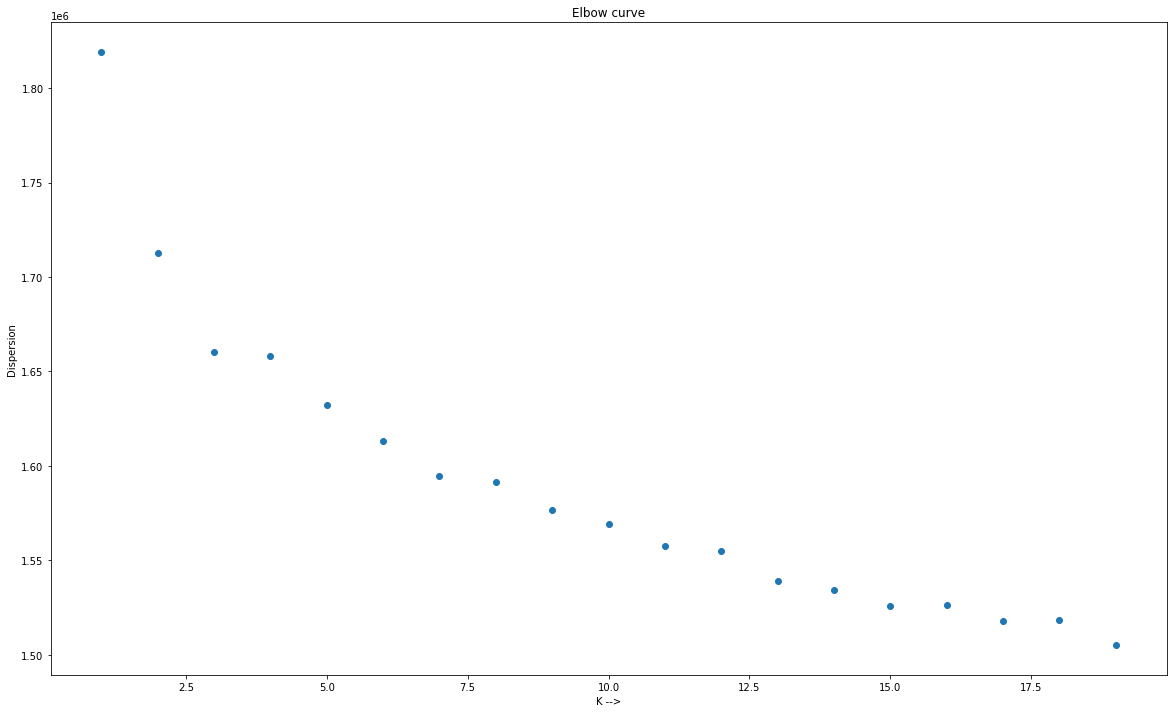

In [ ]:
ordinata=[]
for i in range(1,20):
  dista=0
  K=KMeans(n_clusters=i, init='k-means++').fit(Z)
  d=cdist(Z, K.cluster_centers_, 'euclidean')
  for i in range(Z.shape[0]):
    j=K.labels_[i]
    dista=dista+d[i][j]
  ordinata.append(dista)
ascissa=[]
[ascissa.append(i) for i in range(1,20)]
import matplotlib.pyplot as plt
plt.figure(figsize = (20,12))
plt.scatter(ascissa, ordinata)
plt.title("Elbow curve")
plt.xlabel("K -->")
plt.ylabel("Dispersion")
plt.show()

In this case 13 seems the best number of cluster to choose.

In [ ]:
K=KMeans(n_clusters=13, init='k-means++').fit(Z)

In [ ]:
max(onehundredK["tonnetz_std_02"])

0.16800993680999998

*Characterize your clusters using 5-10 variables.*

In [ ]:
onehundredK["tonnetz02"]=pd.cut(onehundredK["tonnetz_std_02"],np.array([0.005,0.01,0.035,0.05,0.2]), labels=["zero","low","medium","high"])
CT=pd.crosstab(index=onehundredK["tonnetz02"], columns=K.labels_,normalize='columns').round(2)
CT

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12
tonnetz02,,,,,,,,,,,,,
zero,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.6,0.01,0.0,0.00
low,0.97,0.84,0.21,0.78,0.65,0.43,0.49,0.96,0.48,0.2,0.76,0.0,0.92
medium,0.03,0.15,0.58,0.20,0.31,0.51,0.41,0.04,0.44,0.2,0.16,0.0,0.08
high,0.00,0.01,0.21,0.01,0.04,0.06,0.10,0.00,0.07,0.0,0.07,1.0,0.00


In [ ]:
onehundredK["duration"]=pd.cut(onehundredK["track_duration"],np.array([0,150,300,600,18350]), labels=["zero","low","medium","high"])
CT=pd.crosstab(index=onehundredK["duration"], columns=K.labels_,normalize='columns').round(2)
CT

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12
duration,,,,,,,,,,,,,
zero,0.55,0.16,0.27,0.36,0.14,0.29,0.22,0.30,0.16,0.4,0.67,0.0,0.26
low,0.31,0.56,0.33,0.41,0.47,0.47,0.44,0.52,0.57,0.4,0.19,1.0,0.49
medium,0.11,0.24,0.29,0.18,0.26,0.18,0.27,0.14,0.22,0.0,0.10,0.0,0.20
high,0.02,0.04,0.11,0.05,0.13,0.06,0.06,0.03,0.05,0.2,0.04,0.0,0.05


In [ ]:
onehundredK["album_year"]=newdataset2["album_date_created"].str[:4]
CT=pd.crosstab(index=onehundredK["album_year"], columns=K.labels_,normalize='columns').round(2)
CT

col_0,0,1,2,3,4,5,6,7,8,9,10,12
album_year,,,,,,,,,,,,
2008,0.18,0.10,0.10,0.12,0.11,0.09,0.15,0.18,0.16,0.00,0.08,0.16
2009,0.41,0.19,0.24,0.32,0.24,0.30,0.19,0.36,0.25,0.00,0.75,0.32
2010,0.19,0.37,0.33,0.21,0.30,0.28,0.36,0.24,0.32,0.00,0.00,0.26
2011,0.10,0.18,0.12,0.17,0.16,0.16,0.15,0.09,0.15,0.00,0.06,0.14
2012,0.03,0.04,0.09,0.02,0.05,0.04,0.05,0.04,0.06,0.25,0.02,0.05
2013,0.03,0.04,0.05,0.05,0.06,0.04,0.03,0.04,0.03,0.00,0.06,0.03
2014,0.03,0.03,0.05,0.08,0.04,0.04,0.01,0.03,0.01,0.75,0.04,0.03
2015,0.02,0.04,0.02,0.02,0.04,0.04,0.05,0.02,0.03,0.00,0.00,0.02


*Compare your results with those of the previous exercise. If you could choose, would you rather collect more observations (with fewer features) or fewer observations (with more features) based on the previous analyses?*

Looking at the results from the pivot tables, we can notice how it is better to have more information about each single track rather than having too many records to divide in groups. To strenghten this observation of ours, we can notice how variables such as "Year" are correctly divided in the first case, while in the second case the same variable isn't a characteristic one

# 3. Algorithmic question

Given a list A of element and given a value s, we want to know if there are couples in A that summed togheter give the value s. We want also to know which are these couples. <br>
We found three different ways to complete this task: 
<br>
- **1st**: in the first solution we use two for loops to compare every element of the list with all the following elements, but not with those that come before the considered element, returning all the pairs that satisfy the condition just once.  In practice, we compare the element Ai with all the element Aj, with j in [ i+1, len(A) ]. In this case the complexity is O(n<sup>2</sup>), since we have to compare every element with the next one, and as such: T(n)=n(n-1). 


In [ ]:
#ALGORITHM 1
def couples(lst, s):
    lst_couples=[]

    for i in range(len(lst)):   #index of the first element to compare
        for j in range(i+1, len(lst)):      #index of the second element to compare

            if lst[i]+lst[j]==s:
                lst_couples.append((lst[i], lst[j]))    #save the couple if the condition is true
                
    return lst_couples

- **2nd**: to reach our goal, we first sort the array, (python's built-in function has O(nlogn) in the worst case scenario), then we use two indexes, one starting from the left of the array (left=0), and the other one from the right (right=len(A)). Each time, we compare the element in position "left" with the element in position "right": the element on the left will always be smaller than the right one. So, if the sum of element A[left] and A[right] is equal to s, we save the pair; instead, if the sum is bigger than s we know that there won't exist another element that satisfies the condition, since all the elements are sorted: for this reason we increase the index "left", so that by moving it to the left we can start comparing it to a new element. At the end, if none of the conditions are verified, we just move the "right" index, decreasing it. In this example, the complexity obviously depends on the sorting-algorithm chosen for the task: in our case is O(nlogn) in the worst case. 


In [ ]:
#ALGORITHM 2
def couples_sorted(A, s):
    #sort the array in increasing mode
    A.sort()

    #initializing the two index "left" and "right"
    left = 0
    right = len(A)-1
    lst_couples=[]
     
    while left<right:
        #check if the sum of the two elements is equal to s
        if (A[left] + A[right] == s):
               
            lst_couples.append((A[left], A[right]))     #save the couple if true
            right-=1         #decrease the index to compare a new element 

        #check if the sum of the elements is bigger than s    
        elif (A[left] + A[right] < s):   

            left+=1     #increase the index to choose a new element to compare

        else:
            right-=1    #decreasing the index to move to another element

    return lst_couples



- **3rd**: for the last solution we performed an inverse check. First of all, we initialized a empty set, in which we will later add all of the already visited elements. We scroll through all of the elements Ai in A, and for each one we check for the presence in our set of a value (which we called "check") equal to s-Ai. If this value exists, we add the pair (Ai, check) to our list of couples, and then (keep in mind that we always perform this step, indipendently on the outcome of the previous one) we add the element Ai in the set. By doing so, the length of the set will increase for each visited element, and at the end it will contain all of the elements of A. This solution has a linear complexity, O(n), since we had to visit every element just once. (HINT BY GEEKS FOR GEEKS, <a href="https://www.geeksforgeeks.org/count-pairs-two-sorted-arrays-whose-sum-equal-given-value-x/"> "Count pairs from two sorted arrays whose sum is equal to a given value x " </a> and <a href="https://www.geeksforgeeks.org/count-pairs-with-given-sum/"> "Count pairs with given sum" </a>)

In [ ]:
#ALGORITHM 3
def couples_reversing_check(A, s):
     
    #create the list of the visited elements
    visited_elements = set()

    lst_couples=[]

    for i in range(len(A)):
        #compute the inverse sum
        check = s-A[i]

        #check if the inverse sum is in the visited elements
        if check in visited_elements:
            lst_couples.append((A[i], check))       #add it in our list results
        
        #add the already visited element
        visited_elements.add(A[i])
        
    return lst_couples

In [ ]:
A = [7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3]
s = 4
c=couples(A, s)
print("Algorithm 1: ", c)

c2=couples_sorted(A, s)
print("Algorithm 2: ", c2)

c3=couples_reversing_check(A, s)
print("Algorithm 3: ", c3)

Algorithm 1:  [(7, -3), (-2, 6), (2, 2), (1, 3)]
Algorithm 2:  [(-3, 7), (-2, 6), (1, 3), (2, 2)]
Algorithm 3:  [(2, 2), (3, 1), (6, -2), (7, -3)]


**Although the pairs are shown in different order, the returned lists are the same, and therefore contain exactly the same pairs. This shows that all three algorithms work correctly, what changes are only the computational times in the case of large amounts of data.**